## Delaunay Grid Generation

Simple structured Delaunay triangulation in 2D with Bowyer-Watson algorithm.\
Source: http://github.com/jmespadero/pyDelaunay2D\
Based on: http://github.com/ayron/delaunay

In [1]:
import numpy as np
from math import sqrt
import matplotlib.pyplot as plt
import matplotlib

### Generate a few random numbers between 0 and 1

In [2]:
num_points = 20
np.random.seed(1)
points = np.random.rand(num_points, 2)

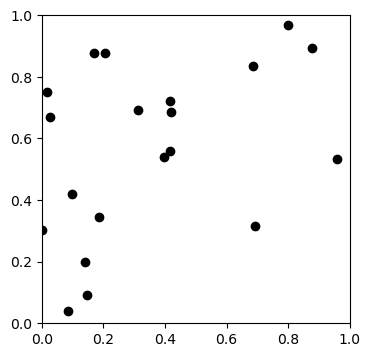

In [3]:
fig,ax=plt.subplots(1,1,figsize=(6,4))
ax.plot(points[:,0],points[:,1],'o',color='k')
ax.set_aspect('equal')
ax.set_xlim(0,1)
ax.set_ylim(0,1)
plt.show()

In [4]:
""" Init and create a new frame to contain the triangulation
center -- Optional position for the center of the frame. Default (0,0)
radius -- Optional distance from corners to the center.
"""
center=(0, 0)
radius=9999

center = np.asarray(center)
# Frame is a square, surrounding the circle with radius=`radius` and center=`center` whose edges are of size 2*radius
# Create coordinates for the corners of the frame
coords = []
coords.append(center + radius * np.array([-1, -1]))
coords.append(center + radius * np.array([1, -1]))
coords.append(center + radius * np.array([1, 1]))
coords.append(center + radius * np.array([-1, 1]))

# Create two dicts to store triangle neighbours and circumcircles.
triangles = {}
circles = {}

# Create two CCW triangles for the frame
T1 = (0, 1, 3) # a tuple made of indices of vertices CCW
T2 = (2, 3, 1) # a tuple made of indices of vertices CCW
triangles[T1] = [T2, None, None] # None means the neighbor is on the boundary
triangles[T2] = [T1, None, None] # None means the neighbor is on the boundary

#So `triangles` is a dictionary with keys as triangles and values as lists of neighbors
# `None` means the neighbor is on the boundary

**Why Tuple?**
Because dictionary keys have to be immutable, so we have to the list of indices into typles if we want to use them as dictionary keys

In [6]:
print("coords:", coords)
print("triangles:", triangles)

coords: [array([-9999, -9999]), array([ 9999, -9999]), array([9999, 9999]), array([-9999,  9999])]
triangles: {(0, 1, 3): [(2, 3, 1), None, None], (2, 3, 1): [(0, 1, 3), None, None]}


### Calculating the circumcenter and circumradius of a triangle in 2D
**Note:** You do not need to understand this function. It is a helper function for the Bowyer-Watson algorithm.

In [7]:
def circumcenter(tri):
        """Compute circumcenter and circumradius of a triangle in 2D.
        Uses an extension of the method described here:
        http://www.ics.uci.edu/~eppstein/junkyard/circumcenter.html
        """
        pts = np.asarray([coords[v] for v in tri])
        pts2 = np.dot(pts, pts.T)
        A = np.bmat([[2 * pts2, [[1],
                                 [1],
                                 [1]]],
                                 [[[1, 1, 1, 0]]]])

        b = np.hstack((np.sum(pts * pts, axis=1), [1])) #numpy transposes it when solving Ax=b
        x = np.linalg.solve(A, b)
        bary_coords = x[:-1]
        center = np.dot(bary_coords, pts)

        # radius = np.linalg.norm(pts[0] - center) # euclidean distance
        radius = np.sum(np.square(pts[0] - center))  # squared distance
        return (center, radius)

In [8]:
# Compute circumcenters and circumradius for each triangle
# Remember circles is a dictionary
for t in triangles:
    circles[t] = circumcenter(t)

In [9]:
print("circles:", circles)

circles: {(0, 1, 3): (array([0., 0.]), np.float64(199960002.0)), (2, 3, 1): (array([0., 0.]), np.float64(199960002.0))}


In [11]:
# Check if point p is inside of precomputed circumcircle of tri.
def inCircleFast(tri, p):
        """Check if point p is inside of precomputed circumcircle of tri.
        """
        center, radius = circles[tri]
        return np.sum(np.square(center - p)) <= radius

In [13]:
# Test out this inCircleFast function
triangle_keys = list(triangles.keys())
print("triangle_keys[0]:",triangle_keys[0], 
      "\ncircles[triangle_keys[0]]:",circles[triangle_keys[0]])
inCircleFast(triangle_keys[0], points[0])

triangle_keys[0]: (0, 1, 3) 
circles[triangle_keys[0]]: (array([0., 0.]), np.float64(199960002.0))


np.True_

___
## Sequentially adding the points inside the frame

**Steps:** Adding a opint to the dataframe:

1. **Convert Point to Array and Append:**
   - Convert the point `p` to a NumPy array.
   - Append this point to the list of coordinates (`coords`).

2. **Identify Bad Triangles:**
   - Initialize an empty list `bad_triangles`.
   - Loop through all existing triangles and check if the point `p` (this newly added point) lies inside their circumcircle using the `inCircleFast` method.
   - If `p` is inside the circumcircle, add the triangle to `bad_triangles`.

3. **Find Boundary of Bad Triangles:**
   - Initialize an empty list `boundary`.
   - Choose a "random" triangle from `bad_triangles` and start with an edge.
   - Loop to find the boundary edges of the bad triangles. If an edge's opposite triangle is not in `bad_triangles`, add the edge to `boundary`.
   - Continue until the boundary forms a closed loop.

4. **Remove Bad Triangles:**
   - Delete all triangles in `bad_triangles` from `triangles` and `circles`.

5. **Retriangle the Hole:**
   - Initialize an empty list `new_triangles`.
   - For each edge in the boundary, create a new triangle using the point `p` and the edge's vertices.
   - Compute and store the circumcenter and circumradius for the new triangle.
   - Set the opposite triangle of the edge as a neighbor of the new triangle.
   - Try to set the new triangle as a neighbor of the opposite triangle.
   - Add the new triangle to `new_triangles`.

6. **Link New Triangles:**
   - Link the new triangles to each other in a counter-clockwise manner.
   - By linking, we mean that for each new triangle, we set its next neighbor to the next triangle in the list and its previous neighbor to the previous triangle in the list.
   - This ensures that all new triangles are connected in a loop, maintaining the Delaunay property.

In [11]:
def addPoint(p):
    """Add a point to the current DT, and refine it using Bowyer-Watson.
    """
    p = np.asarray(p)
    idx = len(coords)
    coords.append(p)

    # Search the triangle(s) whose circumcircle contains p
    bad_triangles = []
    for T in triangles:
        # Choose one method: inCircleRobust(T, p) or inCircleFast(T, p)
        if inCircleFast(T, p):
            bad_triangles.append(T)

    # Find the CCW boundary (star shape) of the bad triangles,
    # expressed as a list of edges (point pairs) and the opposite
    # triangle to each edge.
    boundary = []
    # Choose a "random" triangle and edge
    T = bad_triangles[0]
    edge = 0
    # get the opposite triangle of this edge
    while True:
        # Check if edge of triangle T is on the boundary...
        # if opposite triangle of this edge is external to the list
        tri_op = triangles[T][edge]
        if tri_op not in bad_triangles:
            # Insert edge and external triangle into boundary list
            boundary.append((T[(edge+1) % 3], T[(edge-1) % 3], tri_op))

            # Move to next CCW edge in this triangle
            edge = (edge + 1) % 3

            # Check if boundary is a closed loop
            if boundary[0][0] == boundary[-1][1]:
                break
        else:
            # Move to next CCW edge in opposite triangle
            edge = (triangles[tri_op].index(T) + 1) % 3
            T = tri_op

    # Remove triangles too near of point p of our solution
    for T in bad_triangles:
        del triangles[T]
        del circles[T]

    # Retriangle the hole left by bad_triangles
    new_triangles = []
    for (e0, e1, tri_op) in boundary:
        # Create a new triangle using point p and edge extremes
        T = (idx, e0, e1)

        # Store circumcenter and circumradius of the triangle
        circles[T] = circumcenter(T)
        
        # Set opposite triangle of the edge as neighbour of T
        triangles[T] = [tri_op, None, None]
        
        # Try to set T as neighbour of the opposite triangle
        if tri_op:
            # search the neighbour of tri_op that use edge (e1, e0)
            for i, neigh in enumerate(triangles[tri_op]):
                if neigh:
                    if e1 in neigh and e0 in neigh:
                        # change link to use our new triangle
                        triangles[tri_op][i] = T

        # Add triangle to a temporal list
        new_triangles.append(T)

    # Link the new triangles each another
    N = len(new_triangles)
    for i, T in enumerate(new_triangles):
        triangles[T][1] = new_triangles[(i+1) % N]   # next
        triangles[T][2] = new_triangles[(i-1) % N]   # previous

### Let's test out adding points

In [12]:
# total number of vertexes, triangles and circles we have
print("len(coords):",len(coords))
print("len(triangles):",len(triangles))
print("len(circles):",len(circles))

len(coords): 4
len(triangles): 2
len(circles): 2


In [13]:
for p in points:
    addPoint(p)

print("len(coords):",len(coords))
print("len(triangles):",len(triangles))
print("len(circles):",len(circles))

len(coords): 24
len(triangles): 42
len(circles): 42


### check the triangles shape and type

In [15]:
triangles

{(5, 3, 0): [None, (17, 5, 0), (23, 3, 5)],
 (13, 7, 5): [(19, 5, 7), (17, 13, 5), (21, 7, 13)],
 (14, 2, 3): [None, (18, 14, 3), (16, 2, 14)],
 (15, 9, 4): [(22, 4, 9), (15, 4, 10), (15, 12, 9)],
 (15, 4, 10): [(22, 10, 4), (18, 15, 10), (15, 9, 4)],
 (15, 8, 12): [(21, 12, 8), (15, 12, 9), (19, 8, 15)],
 (15, 12, 9): [(22, 9, 12), (15, 9, 4), (15, 8, 12)],
 (16, 2, 14): [(14, 2, 3), (22, 16, 14), (20, 2, 16)],
 (17, 0, 1): [None, (21, 17, 1), (17, 5, 0)],
 (17, 6, 13): [(21, 13, 6), (17, 13, 5), (21, 6, 17)],
 (17, 13, 5): [(13, 7, 5), (17, 5, 0), (17, 6, 13)],
 (17, 5, 0): [(5, 3, 0), (17, 0, 1), (17, 13, 5)],
 (18, 10, 14): [(22, 14, 10), (18, 14, 3), (18, 15, 10)],
 (18, 14, 3): [(14, 2, 3), (23, 18, 3), (18, 10, 14)],
 (18, 15, 10): [(15, 4, 10), (18, 10, 14), (23, 15, 18)],
 (19, 5, 7): [(13, 7, 5), (19, 7, 8), (19, 11, 5)],
 (19, 7, 8): [(21, 8, 7), (19, 8, 15), (19, 5, 7)],
 (19, 8, 15): [(15, 8, 12), (19, 15, 11), (19, 7, 8)],
 (19, 15, 11): [(23, 11, 15), (19, 11, 5), (19, 8

In [16]:
# only need the dictionary keys
triangles_keys=list(triangles.keys())

In [17]:
plt.triplot(matplotlib.tri.Triangulation(points[:, 0], points[:, 1], triangles_keys))
for i, v in enumerate(points):
    plt.annotate(i, xy=v)
plt.show()

ValueError: triangles are indices into the points and must be in the range 0 <= i < 20 but found value 23

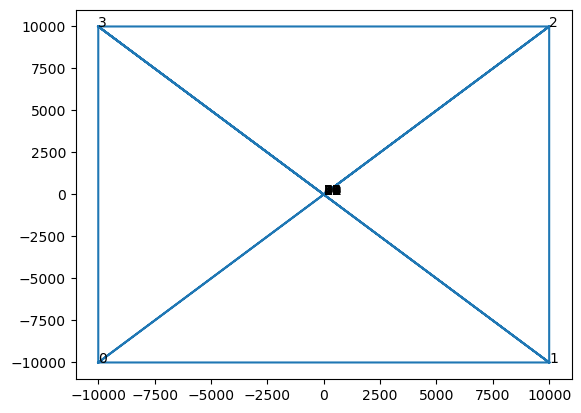

In [18]:
# convert coords to `numpy array` from list of arrays
coords_array=np.array(coords)

plt.triplot(matplotlib.tri.Triangulation(coords_array[:,0], coords_array[:,1], triangles_keys))
for i, v in enumerate(coords_array):
    plt.annotate(i, xy=v)
plt.show()

**Doesn't it look weird???**
Why? where are the points?

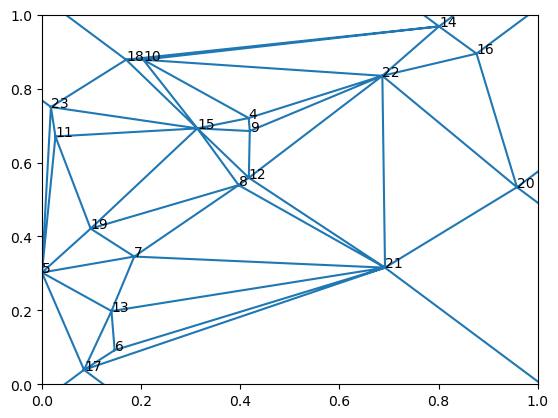

In [19]:
# zoom into the domain [0,1]x[0,1]
plt.triplot(matplotlib.tri.Triangulation(coords_array[:,0], coords_array[:,1], triangles_keys))
for i, v in enumerate(coords_array):
    plt.annotate(i, xy=v)
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()

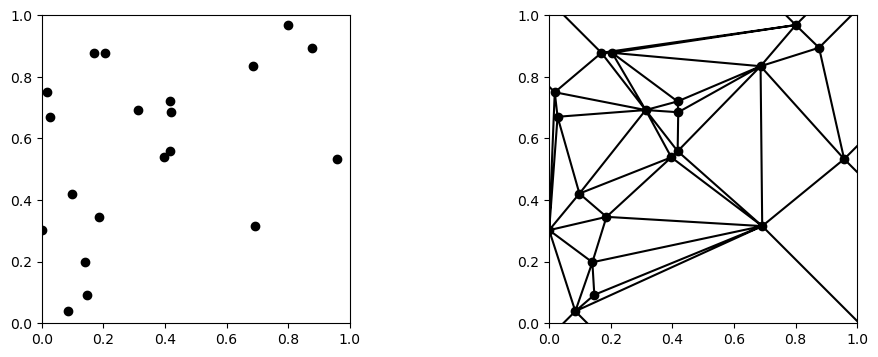

In [22]:
# side-by-side next to the points
fig,ax=plt.subplots(1,2,figsize=(12,4))
#points
ax[0].plot(points[:,0],points[:,1],'o',color='k')
ax[0].set_aspect('equal')
ax[0].set_xlim(0,1)
ax[0].set_ylim(0,1)

#triangles
ax[1].triplot(matplotlib.tri.Triangulation(coords_array[:,0], coords_array[:,1], triangles_keys),'ko-')
ax[1].set_aspect('equal')
ax[1].set_xlim(0,1)
ax[1].set_ylim(0,1)
plt.show()

___
### Create a function get rid of the triangles created by the corners of the frame, reorder the index of vertices to start from 0 to n_points-1 and then export the triangles

In [23]:
def exportTriangles(triangles):
        """Export the current list of Delaunay triangles
        """
        # Filter out triangles with any vertex in the extended Box
        return [(a-4, b-4, c-4)
                for (a, b, c) in triangles if a > 3 and b > 3 and c > 3]

In [ ]:
def exportNeighborsDict(triangles):
        modified_triangles = {}
        for triangle, neighbors in triangles.items():
            # Subtract 4 from each vertex in the key triangle
            new_triangle = tuple(vertex_id - 4 for vertex_id in triangle)
            
            # Check if any vertex in the new key triangle is negative
            if any(vertex_id < 0 for vertex_id in new_triangle):
                continue  # Skip this triangle if any vertex is negative
            
            # Adjust the neighbors list, replace negative indices with None
            new_neighbors = []
            for neighbor in neighbors:
                if neighbor is not None:
                    # Subtract 4 from each vertex in the neighbor triangle
                    adjusted_neighbor = tuple(vertex_id - 4 for vertex_id in neighbor)
                    
                    # Check for any negative vertex
                    if any(vertex_id < 0 for vertex_id in adjusted_neighbor):
                        new_neighbors.append(None)
                    else:
                        new_neighbors.append(adjusted_neighbor)
                else:
                    new_neighbors.append(None)
            
            # Add the adjusted triangle and its neighbors to the new dictionary
            modified_triangles[new_triangle] = new_neighbors

        return modified_triangles

In [24]:
def exportNeighborsDict(triangles):
    modified_triangles = {}
    
    for triangle, neighbors in triangles.items():
        # Create a new list for the adjusted triangle vertices
        new_triangle = []
        for vertex_id in triangle:
            new_triangle.append(vertex_id - 4)
        
        # Check if any vertex in the new key triangle is negative
        # if vertex_id (in the new_triangle) is negative, it means it is a corner of the frame
        if any(vertex_id < 0 for vertex_id in new_triangle):
            continue  # Skip this triangle (loop index) if any vertex is negative (don't add to the new_triangle)
        
        # if a neighbor is None -> this cell is on the boundaries
        # Adjust the neighbors list, replace negative indices with None
        new_neighbors = []
        for neighbor in neighbors:
            if neighbor is not None:
                # Create a new list for the adjusted neighbor vertices (-4)
                adjusted_neighbor = []
                for vertex_id in neighbor:
                    adjusted_neighbor.append(vertex_id - 4)
                
                # Check for any negative vertex
                if any(vertex_id < 0 for vertex_id in adjusted_neighbor):
                    new_neighbors.append(None)
                else:
                    new_neighbors.append(adjusted_neighbor)
            else:
                new_neighbors.append(None)
        
        # Convert lists back to tuples for dictionary keys
        # dictionary keys have to be immutable, so we have to turn them into keys
        modified_triangles[tuple(new_triangle)] = new_neighbors

    return modified_triangles

In [25]:
tri = exportTriangles(triangles)
neighborsDict=exportNeighborsDict(triangles)